In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
import warnings

import datetime as dt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label='',title=''):
    fig = plt.figure(3, figsize=(10,10))
    ax=plt.axes(projection='3d')
    ax.set_title(title)
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Days To Expiration')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()

In [2]:
%%time

INSTRUMENT="BTC"

# Get a list of all active BTC options from the Deribit API.
def get_all_active_options(instrument_name):
    import urllib.request, json
    url =  f"https://deribit.com/api/v2/public/get_instruments?currency={instrument_name}&kind=option&expired=false"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.')
    return data

# Filter options based on data available from 'get_instruments'
def filter_options(price, active_options):
    # price is the current price of BTC
    
    #Get Put/Call information
    pc = active_options.index.str.strip().str[-1]
    
    # Set "moneyness"
    active_options['m'] = np.log(active_options['strike']/price)
    active_options.loc[pc=='P','m'] = -active_options['m']
    # Set days until expiration
    active_options['t'] = (active_options['expiration_date']-pd.Timestamp.today()).dt.days
    
    # Only include options that are less than 30% from the current price and have less than 91 days until expiration
    active_options = active_options.query('m>0 & m<.3 & t<91')
    
    print(f'{active_options.shape[0]} active options after filter.')
    return active_options

# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name):
    import urllib.request, json
    url =  f"https://deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = json_normalize(data['result'])
    data.index = [instrument_name]
    return data

# Loop through all filtered options to get the current 'ticker' datas
def get_all_option_data(instrument_name):
    option_data = get_tick_data(f'{instrument_name}-PERPETUAL')
    options = filter_options(option_data['last_price'][0], get_all_active_options(instrument_name))
    for o in options.index:
        option_data = option_data.append(get_tick_data(o))
    return option_data

def get_final_data_transformed(instrument_name):
    option_data = get_all_option_data(instrument_name)
    ### Add additional metrics to data
    option_data['t'] = np.nan; option_data['strike'] = np.nan
    # Calculated days until expiration
    option_data.loc[1:,'t'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
    # Pull strike from instrument name
    option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
    # Calculate "moneyness"
    option_data['m'] = np.log(option_data['last_price'][0]/option_data['strike'])
    
    return option_data
    
option_data = get_final_data_transformed('BTC')

562 active options.
106 active options after filter.
CPU times: user 4.39 s, sys: 471 ms, total: 4.87 s
Wall time: 2min 6s


In [3]:
minMoneyness = 0.75
maxMoneyness = 1.25

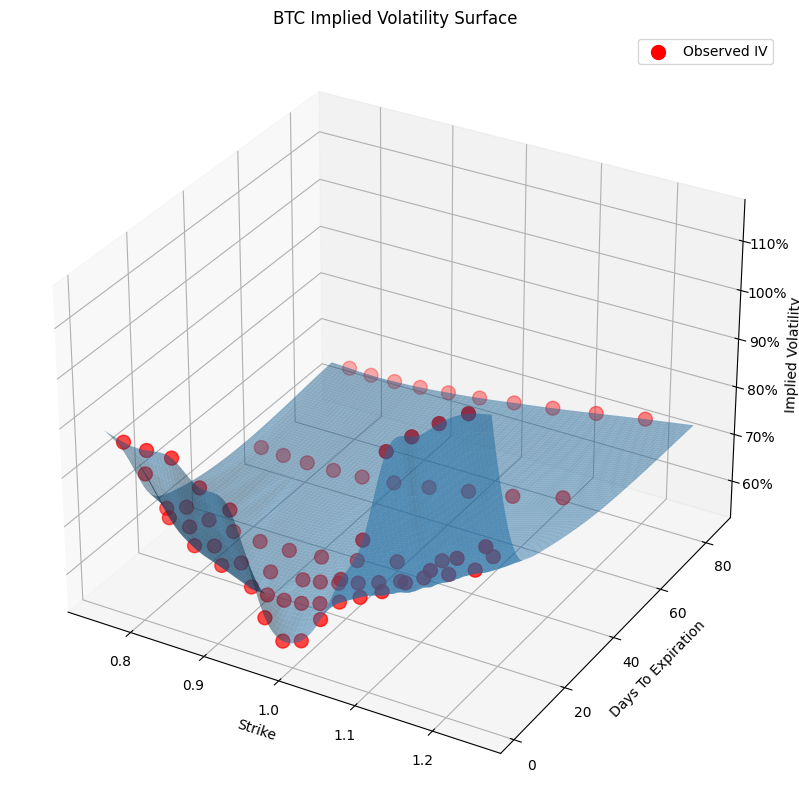

In [4]:
# Interpolate implied volatility using a cubic spline
# Then plot the implied volatility surface

def get_interpolated_points(option_data):
    option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')
    x = (option_data['last_price'][0]/option_data_['strike'])
    y = option_data_['t']
    z = option_data_['mark_iv']/100

    X,Y = np.meshgrid(np.linspace(minMoneyness,maxMoneyness,99),np.linspace(1,np.max(y),100))
    Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')
    
    return [x,y,z,X,Y,Z]

[x,y,z,X,Y,Z] = get_interpolated_points(option_data)

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>'+ str(minMoneyness)+' & x<'+ str(maxMoneyness))
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV', f'{INSTRUMENT} Implied Volatility Surface')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(minMoneyness,maxMoneyness,99))

In [5]:
%%time

eth_option_data = get_final_data_transformed('ETH')

580 active options.
86 active options after filter.
CPU times: user 3.63 s, sys: 382 ms, total: 4.01 s
Wall time: 1min 41s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


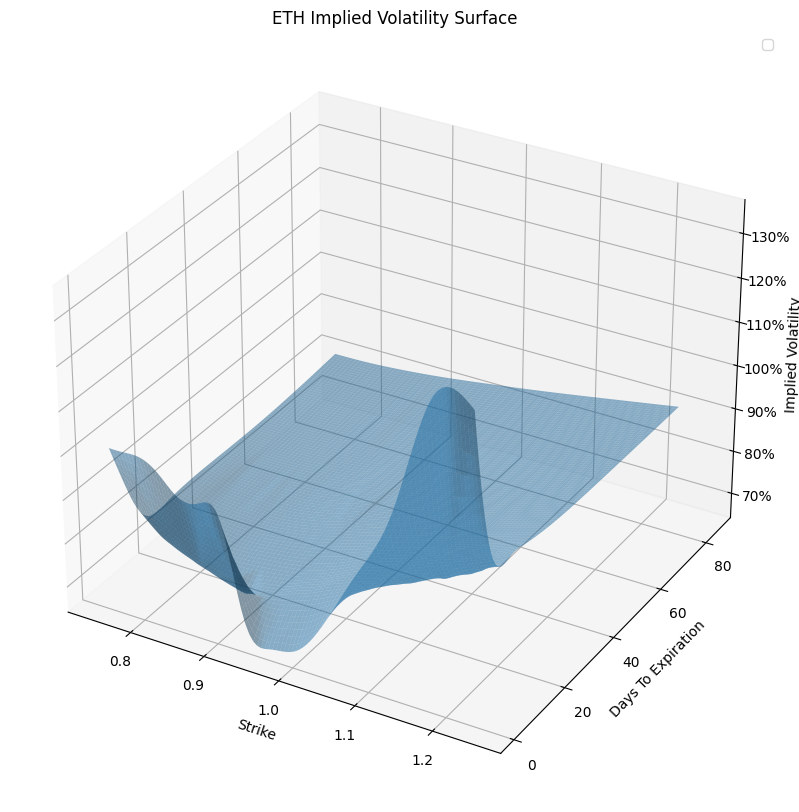

In [6]:
[_,_,_,_,_,eth_Z] = get_interpolated_points(eth_option_data)
plot_iv_surf(X,Y,eth_Z,None,None,None,'Observed IV','ETH Implied Volatility Surface')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


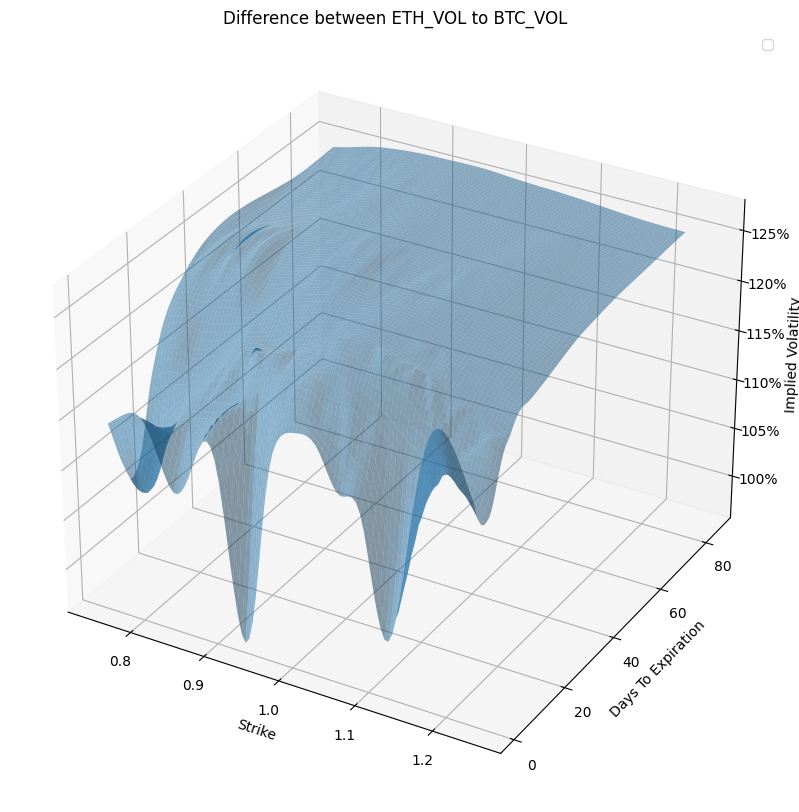

In [7]:
plot_iv_surf(X,Y,eth_Z / Z,None,None,None,'Observed IV','Difference between ETH_VOL to BTC_VOL')


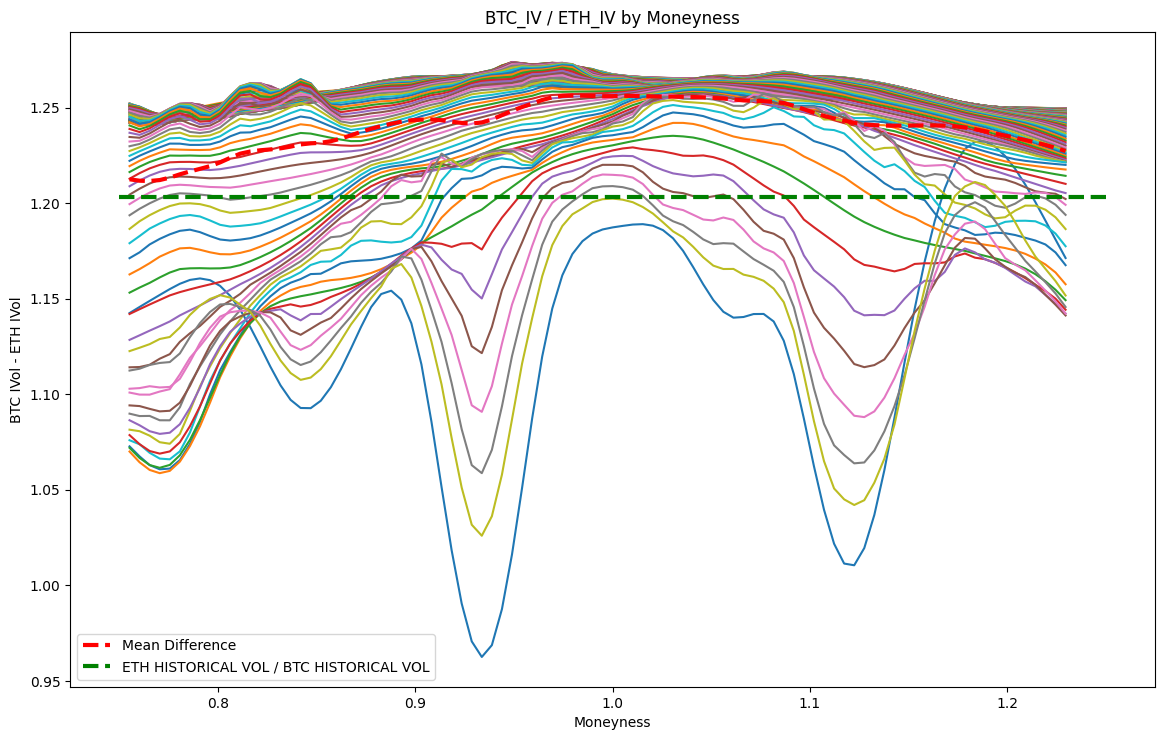

In [8]:
diff_Z = eth_Z / Z
fig, ax = plt.subplots(figsize = (14, 8.5))

for i in range(len(Z[0,:])):
        ax.plot( X[0,:], diff_Z[-i,:])

ax.set_xlabel('Moneyness')
ax.set_ylabel('BTC IVol - ETH IVol')

ax.plot(X[0,:], np.mean(diff_Z, axis=0) ,color='red', linestyle='dashed',
     linewidth=3, markersize=2, label="Mean Difference")

ax.plot(X[0,:],np.ones(99)*0.71/0.59,color='green', linestyle='dashed',
    linewidth=3, markersize=2, label="ETH HISTORICAL VOL / BTC HISTORICAL VOL")
ax.legend()
ax.set_title('BTC_IV / ETH_IV by Moneyness')
plt.show()

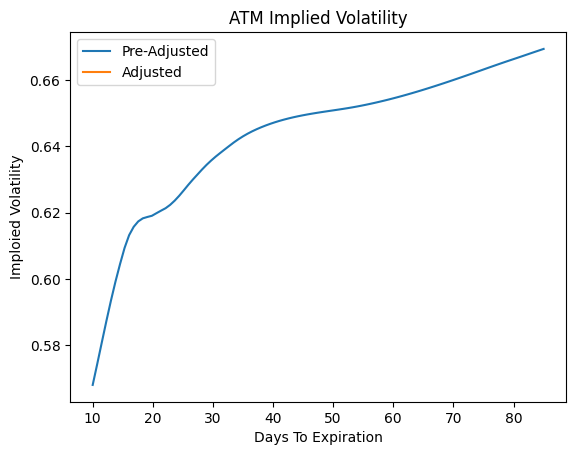

In [9]:
price_diff = option_data['mark_price'][0]-option_data['underlying_price']
option_data['iv_adj'] = option_data['mark_iv']+(option_data['greeks.delta']*price_diff)/(option_data['greeks.vega'])
option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')

Z_adj = interpolate.griddata(np.array([x,y]).T,np.array(option_data_['iv_adj']/100),(X,Y), method='cubic')
iv_df_adj = pd.DataFrame(Z_adj, index=np.linspace(10,np.max(y),100), columns=np.linspace(minMoneyness,maxMoneyness,99))
iv_df.loc[:,1].plot(label='Pre-Adjusted')
(iv_df_adj.loc[:,1]).plot(label='Adjusted')
plt.xlabel('Days To Expiration')
plt.ylabel('Imploied Volatility')
plt.legend()
plt.title('ATM Implied Volatility')
plt.show()

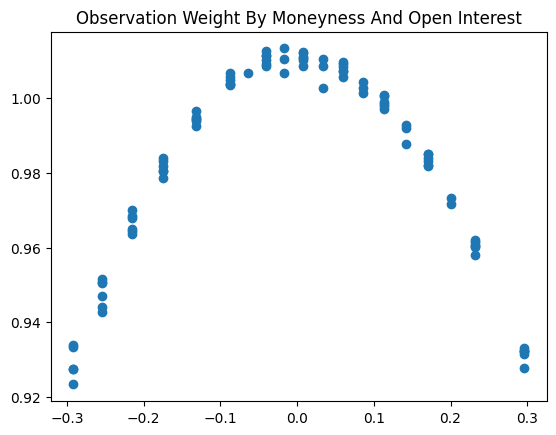

In [10]:
weights = 1/(1+((option_data_['m']**2)))+((np.log(option_data_['open_interest']).replace(-np.inf,0)/np.log(option_data_['open_interest']).replace(-np.inf,0).sum()))
plt.scatter(option_data_['m'],weights)
plt.title('Observation Weight By Moneyness And Open Interest')
plt.show()